In [9]:
import pandas as pd
import numpy as np
import spacy
import re

In [47]:
# read in emails
df = pd.read_csv('../storage/updated_emails_fri_nov22.csv')

print(df.shape)

df.head()

(11201, 8)


,From,Message,Subject,Tags,UID,text,tag_list,first_tag
0,<grangepayments@westernunionspeedpay.com>,"Dear AVRAHAM JACOBSOHN, This is to confirm th...",Grange Payment Confirmation,Finance,31780,<grangepayments@westernunionspeedpay.com> Gran...,['Finance'],Finance
1,Chase <no.reply.alerts@chase.com>,This is an Alert to help manage your account ...,Your Debit Card Transaction,Finance,31779,Chase <no.reply.alerts@chase.com> Your Debit C...,['Finance'],Finance
2,Amazon Web Services <no-reply-aws@amazon.com>,Please let us know if we helped resolve your i...,Resolved 6559329691: Limit Increase: SageMaker,Productivity,31738,Amazon Web Services <no-reply-aws@amazon.com> ...,['Productivity'],Productivity
3,Lambda Labs <noreply@github.com>,Youve been added to the Labs 18 - Tagger team ...,Bernie Durfee added you to the Lambda Labs tea...,Productivity,31693,Lambda Labs <noreply@github.com> Bernie Durfee...,['Productivity'],Productivity
4,Amazon Web Services <no-reply-aws@amazon.com>,"Hello, We haven't heard back from you regard...",Attention required on case 6559329691: Limit I...,Productivity,31684,Amazon Web Services <no-reply-aws@amazon.com> ...,['Productivity'],Productivity


In [49]:
# NaN are only in the Subject or Message fields
# Can just replace with empty spaces, no need to lose the whole row
df = df.fillna('')

In [62]:
# pulling off just the sender name from the email address
# this is text that comes before the actual address in some of the emails
# the other emails just get a space for this value
df['sender_name'] = [s.split('<')[0] if (len(s.split('<'))>1) else ' ' for s in df['From']]
df['sender_name'] = df['sender_name'].str.replace('"', '')
df['sender_name']

0                                
1                          Chase 
2            Amazon Web Services 
3                    Lambda Labs 
4            Amazon Web Services 
                   ...           
11196        Medium Daily Digest 
11197             Glassdoor Jobs 
11198        Amazon Web Services 
11199    no-reply-aws@amazon.com 
11200        Medium Daily Digest 
Name: sender_name, Length: 11201, dtype: object

In [110]:
# using regex to extract the email address part of the From column
emails = []
pattern = '\<(.*?)\>'
for val in df['From'].values:
    match = re.findall(pattern, val)
    if len(match)>0: # this means a match was found
        emails.append(match)
    else: # if no match is found, the raw text was already what we were looking for
        emails.append(val)
df['sender_email'] = emails

In [116]:
# extract the string from the list
df['sender_email'] = [s[0] if (type(s)==list) else s for s in df['sender_email']]

In [118]:
df['sender_email'].head(50)

0           grangepayments@westernunionspeedpay.com
1                         no.reply.alerts@chase.com
2                           no-reply-aws@amazon.com
3                                noreply@github.com
4                           no-reply-aws@amazon.com
5                         no.reply.alerts@chase.com
6                         no.reply.alerts@chase.com
7                           no-reply-aws@amazon.com
8                           no-reply-aws@amazon.com
9                         no.reply.alerts@chase.com
10                               noreply@github.com
11                               noreply@github.com
12                               noreply@github.com
13                               noreply@github.com
14                        no.reply.alerts@chase.com
15                   no-reply@accounts.nintendo.com
16                   no-reply@accounts.nintendo.com
17                        no.reply.alerts@chase.com
18                        no.reply.alerts@chase.com
19          

In [120]:
# use regex to extract domain name of email address
domains = []
pattern = '\@(.*?)\.'
for val in df['sender_email']:
    match = re.findall(pattern, val)
    domains.append(match)
df['domain_name'] = domains

In [122]:
# again get just the name from the list
df['domain_name'] = [s[0] for s in df['domain_name']]

In [126]:
# look at the distribution of domains
df['domain_name'].value_counts()

amazon                    5163
jdeal                      752
designsbyfmc               679
pokerstars                 548
twoplustwo                 449
                          ... 
discordapp                   1
correo                       1
steampowered                 1
QuestDiagnosticsSurvey       1
netvision                    1
Name: domain_name, Length: 418, dtype: int64

In [136]:
# binary column if the email comes from noreply@
# uses this syntax bec of differences in the email string
df['isNoReply'] = ((df['From'].str.contains('no')) & df['From'].str.contains('reply'))

df['isNoReply'].value_counts()

True     5753
False    5448
Name: isNoReply, dtype: int64

In [137]:
# save to csv
df.to_csv('update_twelve_two.csv', index=False)

## Below here is more messing around, figuring out what feature extraction to do

In [7]:
def tokenize(text):
    """Parses a string into a list of semantic units (words)

    Args:
        text (str): The string that the function will tokenize.

    Returns:
        list: tokens parsed out by the mechanics of your choice
    """
    
    tokens = re.sub(r'[^a-zA-Z ^0-9]', '', text)
    tokens = tokens.lower().split()
    
    return tokens

In [10]:
df['tokens'] = df['text'].apply(tokenize)

In [11]:
# Object from Base Python
from collections import Counter

# The object `Counter` takes an iterable, but you can instaniate an empty one and update it. 
word_counts = Counter()

# Update it based on a split of each of our documents
df['tokens'].apply(lambda x: word_counts.update(x))

# Print out the 10 most common words
word_counts.most_common(10)

[('to', 38618),
 ('the', 34244),
 ('you', 25754),
 ('for', 23721),
 ('amazon', 22636),
 ('a', 22010),
 ('and', 20838),
 ('from', 18161),
 ('your', 16784),
 ('td', 15860)]

In [12]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [13]:
wc = count(df['tokens'])

In [14]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
50,to,8198,38618,1.0,0.020716,0.020716,0.731899
14,the,4993,34244,2.0,0.018370,0.039086,0.445764
46,you,9824,25754,3.0,0.013815,0.052902,0.877065
37,for,9264,23721,4.0,0.012725,0.065626,0.827069
122,amazon,5224,22636,5.0,0.012143,0.077769,0.466387


In [16]:
wc.sort_values(by='pct_total', ascending=False)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
50,to,8198,38618,1.0,2.071623e-02,0.020716,0.731899
14,the,4993,34244,2.0,1.836985e-02,0.039086,0.445764
46,you,9824,25754,3.0,1.381547e-02,0.052902,0.877065
37,for,9264,23721,4.0,1.272489e-02,0.065626,0.827069
122,amazon,5224,22636,5.0,1.214285e-02,0.077769,0.466387
...,...,...,...,...,...,...,...
25911,zad2nzexs9w8cme6nzxrn0izq9lops9jdaix9x9c3mvnt0...,1,1,91282.0,5.364398e-07,0.951794,0.000089
6741,rvoeo5j7dzq3bbglkvcptpcegtauhh54ydcc99mekpxki1...,1,1,91281.0,5.364398e-07,0.951794,0.000089
9303,uvi093q0e8najelqx4tb5o33j0njrucee1p8xshnbq6sl8...,1,1,91280.0,5.364398e-07,0.951793,0.000089
30096,2knylbephrpzpk8fscxwwdbd6lp7m1wdsiqcbpwhpqfnz8...,1,1,91279.0,5.364398e-07,0.951793,0.000089


In [18]:
wc.sort_values(by='appears_in', ascending=False).head(20)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
46,you,9824,25754,3.0,0.013815,0.052902,0.877065
37,for,9264,23721,4.0,0.012725,0.065626,0.827069
18,from,8706,18161,8.0,0.009742,0.110497,0.777252
50,to,8198,38618,1.0,0.020716,0.020716,0.731899
54,please,8141,11134,16.0,0.005973,0.169694,0.726810
386,our,6827,8607,20.0,0.004617,0.190011,0.609499
283,information,6803,8194,21.0,0.004396,0.194407,0.607356
76,about,6632,7469,25.0,0.004007,0.211158,0.592090
11,a,6370,22010,6.0,0.011807,0.089576,0.568699
284,visit,6062,6240,34.0,0.003347,0.243096,0.541202


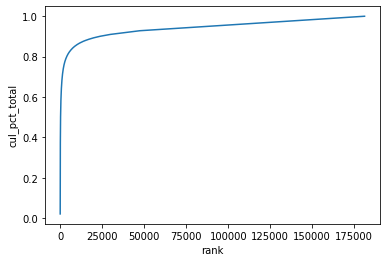

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
# Cumulative Distribution Plot
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

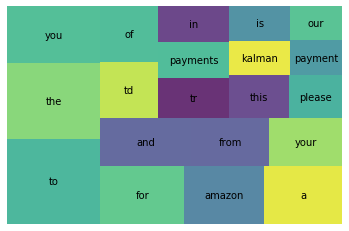

In [23]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [34]:
from spacy.tokenizer import Tokenizer

tokenizer = Tokenizer(nlp.vocab)

In [44]:
df.isna().sum()

From         0
Message      0
Subject      0
Tags         0
UID          0
text         0
tag_list     0
first_tag    0
tokens       0
dtype: int64

In [43]:
df.fillna('', inplace=True)

In [45]:
tokens = []

for doc in tokenizer.pipe(df['Subject'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text not in nlp.Defaults.stop_words:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
df['tokens'] = tokens

In [48]:
wc = count(df['tokens'])

wc.head(40)

KeyError: 'tokens'